In [1]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [2]:
import os
import json
import glob
import re

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from Faraday.two_dim import matplotlib_style
from Faraday.two_dim.module.lib.layers import *
matplotlib_style.paper()

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11490434/11490434 [==============================] - 0s 0us/step


# 連続

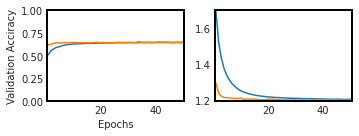

In [16]:
path1 = "trained_model/20230206/z0_0.000500_seed_1"
path2 = "trained_model/20230206/bi_z0_0.000500_seed_1"

df1 = pd.read_csv(path1 + "/history.csv")
df2 = pd.read_csv(path2 + "/history.csv")
epochs = np.arange(len(df1["val_loss"])) + 1

fig, axes = plt.subplots(1, 2, figsize=(5,2))
axes[0].plot(epochs, df1["val_accuracy"], label="co")
axes[0].plot(epochs, df2["val_accuracy"], label="Binary")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Validation Acciracy")

axes[1].plot(epochs, df1["val_loss"])
axes[1].plot(epochs, df2["val_loss"])

fig.tight_layout()

In [4]:
path = "trained_model/20230206/z0_0.000500_seed_1"
model = tf.keras.models.load_model(path)

/tmp/ipykernel_126/159048775.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


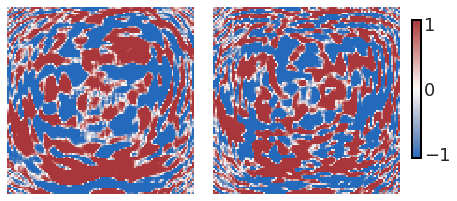

In [24]:
matplotlib_style.paper()

faraday1 = model.layers[5].get_limited_complex_faraday()
faraday2 = model.layers[7].get_limited_complex_faraday()

fig, axes = plt.subplots(1, 2)
image1 = axes[0].imshow(faraday1.numpy().real * 180 / np.pi, cmap=sns.color_palette("vlag", as_cmap=True))
image2 = axes[1].imshow(faraday2.numpy().real * 180 / np.pi, cmap=sns.color_palette("vlag", as_cmap=True))
axes[0].axis(False)
axes[1].axis(False)

ax_pos1 = axes[1].get_position()
cax = fig.add_axes([ax_pos1.x0+0.4, ax_pos1.y0, 0.02, ax_pos1.height])
fig.colorbar(image2, cax)
fig.tight_layout()
fig.savefig("out/paper/8/mult_layer.png", dpi=300)

In [5]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 1.2570 - accuracy: 0.6210


[1.2570160627365112, 0.6209999918937683]

# 2値

In [6]:
path = "trained_model/20230206/bi_z0_0.000500_seed_1"
model = tf.keras.models.load_model(path)

In [7]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 1.2527 - accuracy: 0.6225


[1.2526949644088745, 0.6225000023841858]

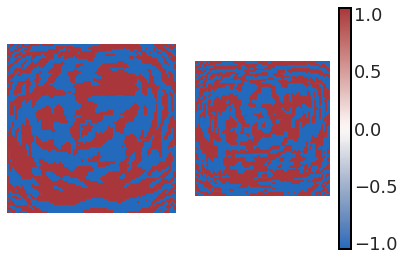

In [34]:
theta = model.layers[5].get_config()["theta"]
w1 = model.layers[5].get_weights()
b_w1 = tf.clip_by_value((w1[0]+1.)/2.,0, 1)
b_w1 = 2.*tf.round(b_w1)-1.

w2 = model.layers[7].get_weights()
b_w2 = tf.clip_by_value((w2[0]+1.)/2.,0, 1)
b_w2 = 2.*tf.round(b_w2)-1.

fig, axes = plt.subplots(1, 2)
image1 = axes[0].imshow(b_w1 * 180 / np.pi * theta, cmap=sns.color_palette("vlag", as_cmap=True))
image2 = axes[1].imshow(b_w2 * 180 / np.pi * theta, cmap=sns.color_palette("vlag", as_cmap=True))
axes[0].axis(False)
axes[1].axis(False)

ax_pos1 = axes[1].get_position()
cbar = fig.colorbar(image2)
fig.tight_layout()
fig.savefig("out/paper/8/bi_layer_colorbar.png", dpi=300)

In [47]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

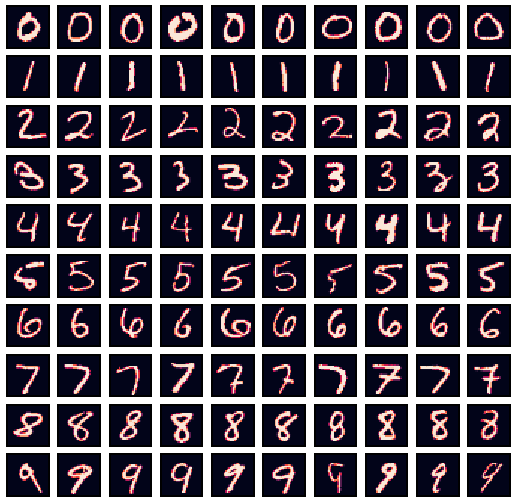

In [48]:
N_type = 10
N_img = 10

fig, axes = plt.subplots(N_type, N_img, figsize=(10,10))

for i, _ax in enumerate(axes):
    for j , ax in enumerate(_ax):
        ax.imshow(test_data[list(test_data.keys())[i]][j,:,:])
        ax.set_xticks([],[])
        ax.set_yticks([],[])

In [1]:
test_array = np.array(list(test_data.values()))
test_array = test_array.reshape((-1,28,28))

NameError: name 'np' is not defined

In [ ]:
hidden_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
hidden_pred = hidden_model.predict(test_array)

pred = model.predict(test_array)

In [ ]:
N_type = 10
N_img = 10

fig, axes = plt.subplots(N_type, N_img*4, figsize=(40,10))
theta_b = abs(model.layers[4].get_config()["theta"])

mask = np.sum(MNISTDetector.make_filters_v1((100, 100)), axis=0)
for i in range(N_type):
    for j in range(N_img):
        axes[i, j].imshow(test_array[i*10 + j])

        axes[i, j+10].imshow(hidden_pred[i*10 + j], vmax=theta_b*1.1, vmin=-theta_b*1.1)

        axes[i, j+20].imshow(hidden_pred[i*10 + j] * mask, vmax=theta_b*2*1.1, vmin=-theta_b*2*1.1)

        axes[i, j+30].bar(np.arange(0, 10, 1), pred[i*10 + j, :], align='center')
        axes[i, j+30].set_xticks(np.arange(0, 10, 1))

for i, _ax in enumerate(axes):
    for j , ax in enumerate(_ax):
        ax.set_xticks([],[])
        ax.set_yticks([],[])

fig.savefig("images/GGG_model1_outputs_faraday.png", dpi=400)